[![Open In Colab](https://colab.research.google.com/assets/colab-badge.png)](https://colab.research.google.com/github/juansensio/axr/blob/master/axr/03_dp.ipynb)

# Programación Dinámica

En el post anterior definimos los procesos de decisión de Markov y cómo podemos usarlos para formular el problema del AxR y resolverlo mediante la ecuación de optimalidad de Bellman. También vimos los diferentes tipos en los que podemos clasificar los métodos y algoritmos de AxR más comunes. En este post vamos a introducir de manera formal nuestro primer algoritmo de AxR, conocido como programación dinámica.

## Métodos Tabulares

Como ya vimos en el post anterior, los métodos tabulares son capaces de encontrar las funciones de valor y políticas óptimas, las cuales pueden ser representadas como una *tabla*. Sin embargo, este tipo de métodos solo podrán ser aplicados en aquellos casos en los que el conjunto de estados y acciones del entorno sean lo suficientemente pequeños como para poder ser representados en la tabla. Existen multitud de métodos tabulares desarrollados durante los años, pero la mayoría pueden encajarse en la siguiente figura.

![](./pics/tabular.png)

Si conocemos la dinámica entera de un entorno, y el espacio de estados y acciones no es muy grande, lo primero que podemos pensar es en recorrer todo este espacio en una **búsqueda exhaustiva**. Esta aproximación, sin embargo, no será factible en la mayoría de casos interesantes. Así pues, diferentes alternativas existen. En el caso de disponer de un modelo del entorno, el uso de la **programación dinámica** es una buena primera aproximación. En el caso de no disponer de un modelo del entorno, métodos de tipo **Monte Carlo** o **temporal-difference learning** nos permiten aprender un comportamiento óptimo a través de la interacción. En este post hablaremos sobre métodos de programación dinámica, mientras que en los siguientes nos enfocaremos a las alternativas *model-free*.

## Programación Dinámica

El término *programación dinámica* (DP, *dynamic programming*) se refiere al conjunto de algoritmos usados para encontrar la política óptima en MDPs con un modelo del entrono perfectamente caracterizado. Este hecho, junto a que son computacionalmente exigentes, no los hace muy prácticos hoy en día, aún así siguen siendo interesantes desde un punto de vista teórico. Los algoritmos de DP se basan en el uso de funciones de valor para organizar y estructurar la búsqueda de buenas políticas, utilizando las ecuaciones de optimidad de Bellman.

$$
   v_*(s) = \max_a \sum_{s',r} p(s',r|s,a) [r + \gamma v_*(s')]
$$

$$
   q_*(s,a) = \sum_{s',r} p(s',r|s,a) [r + \gamma \max_{a'} q_*(s',a')]
$$

## Evaluación de la política

Vamos a ver cómo calcular la función de valor $v_\pi$ para una política $\pi$ cualquiera, esto se llama *evaluación de la política*. 


$$
   v_\pi(s) = \sum_a \pi(a|s) \sum_{s',r} p(s',r|s,a) [r + \gamma v_\pi(s')]
$$

donde $\pi(a|s)$ es la probabilidad de tomar la acción $a$ en el estado $s$ bajo la política $\pi$. Si las dinámicas del entrono son completamente conocidas, podemos utilizar un método de resolución iterativo:

$$
   v_{k+1}(s) = \sum_a \pi(a|s) \sum_{s',r} p(s',r|s,a) [r + \gamma v_k(s')]
$$

Cuando $k \rightarrow \infty$ entonces $v_k$ converge a $v_\pi$. Este algoritmo se conoce como *evaluación iterativa de la política*. Para cada paso iterativo, se aplica la misma operación en cada estado $s$ reemplazando el antigo valor por el nuevo.

Consideremos como ejemplo un entorno como el siguiente

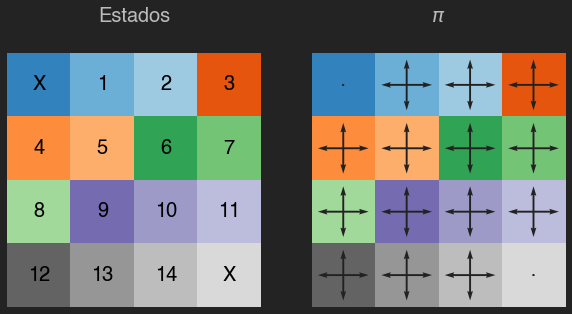

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def plot_env(v, a=None, title="$v_k$"):
    v = v.reshape(4,4)
    if a is None:
        R, T = np.ones((4,4)), np.ones((4,4))
        L, B = -1.*R, -1.*T
    else:
        T = a[:,0].reshape((4,4))
        B = -1*a[:,1].reshape((4,4))
        R = a[:,2].reshape((4,4))
        L = -1*a[:,3].reshape((4,4))
    R[0,0], R[3,3] = 0, 0
    T[0,0], T[3,3] = 0, 0
    B[0,0], B[3,3] = 0, 0
    L[0,0], L[3,3] = 0, 0
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    zeros = np.zeros((4,4))
    ax1.matshow(v, cmap=plt.cm.tab20c)
    ax2.matshow(v, cmap=plt.cm.tab20c)
    for i in range(4):
        for j in range(4):
            c = v[j,i]
            if (i==0 and j==0) or (i==3 and j==3):
                ax1.text(i, j, 'X', va='center', ha='center', fontsize=20, color="black")
            else:
                ax1.text(i, j, f'{round(c,1)}', va='center', ha='center', fontsize=20, color="black")
    ax2.quiver(L, zeros, scale=10)
    ax2.quiver(R, zeros, scale=10)
    ax2.quiver(zeros, T, scale=10)
    ax2.quiver(zeros, B, scale=10)
    ax1.axis(False)
    ax1.set_title(title, fontsize=20)
    ax2.axis(False)
    ax2.set_title("$\pi$", fontsize=20)
    plt.show()
    
estados = np.arange(16)
plot_env(estados, title="Estados")

Nuestro entrono se compone de 16 casillas, y en cada casilla nuestro agente puede tomar 1 acción de entre 4: subir, bajar, derecha o izquierda. Todas las acciones tienen una recompensa de -1, y el objetivo del agente es navegar el entorno para llegar a cualquiera de las dos casillas marcadas con una X.

In [35]:
def init_env():
    probas_transiciones = np.zeros((16,4,16))
    recompensas = -1*np.ones((16,4,16)) # todas a -1

    # acciones: 0 (arriba), 1 (abajo), 2 (derecha), 3(izquierda)
    for s in range(16):
        # arriba
        if s<4:
            probas_transiciones[s,0,s] = 1
        else:
            probas_transiciones[s,0,s-4] = 1
        # abajo
        if s<12:
            probas_transiciones[s,1,s+4] = 1
        else:
            probas_transiciones[s,1,s] = 1
        # derecha
        if (s+1) % 4 == 0:
            probas_transiciones[s,2,s] = 1
        else:
            probas_transiciones[s,2,s+1] = 1
        # izquierda
        if s % 4 == 0:
            probas_transiciones[s,3,s] = 1
        else:
            probas_transiciones[s,3,s-1] = 1

    # estados terminales
    probas_transiciones[0, :,:] = 0
    probas_transiciones[15, :,:] = 0
    recompensas[0,:,:] = 0
    recompensas[15,:,:] = 0
    
    return probas_transiciones, recompensas

probas_transiciones, recompensas = init_env()

En este primer ejemplo usaremos una política consistente en tomar una de las 4 acciones con la misma probabilidad, en este caso un 25%.

In [36]:
pi = 0.25*np.ones((16, 4))

In [37]:
def eval_pol(pi, gamma=1, its=100, v=None):
    v = np.zeros(16) if v is None else v
    for it in range(its):
        v_prev = v.copy()
        for s in range(16):
            v[s] = np.sum([
                pi[s,a]*np.sum([
                    probas_transiciones[s][a][sp]*(recompensas[s][a][sp] + gamma*v_prev[sp]) 
                    for sp in range(16)
                ])
                for a in range(4)
            ])
    return v

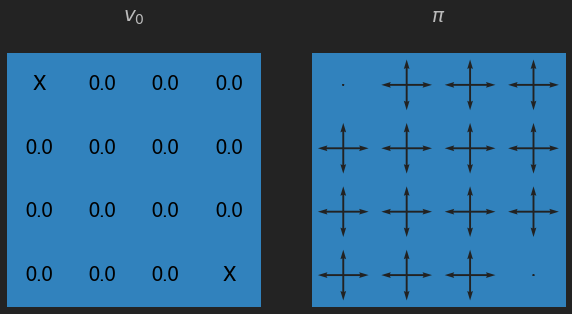

In [38]:
v = eval_pol(pi, its=0)
plot_env(v, title="$v_0$")

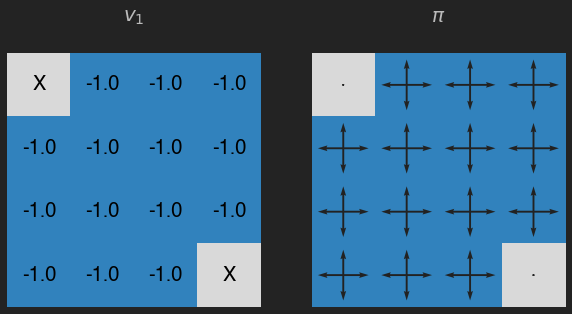

In [39]:
v = eval_pol(pi, its=1)
plot_env(v, title="$v_1$")

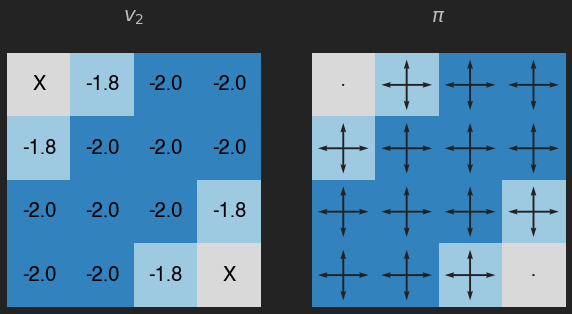

In [40]:
v = eval_pol(pi, its=2)
plot_env(v, title="$v_2$")

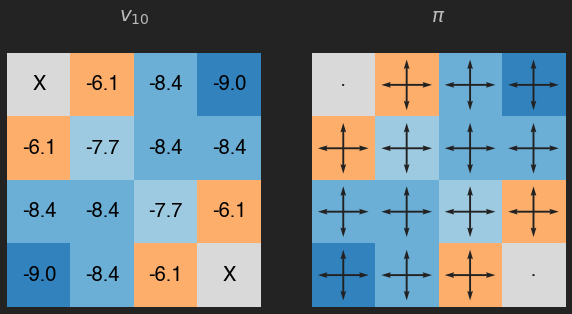

In [41]:
v = eval_pol(pi, its=10)
plot_env(v, title="$v_{10}$")

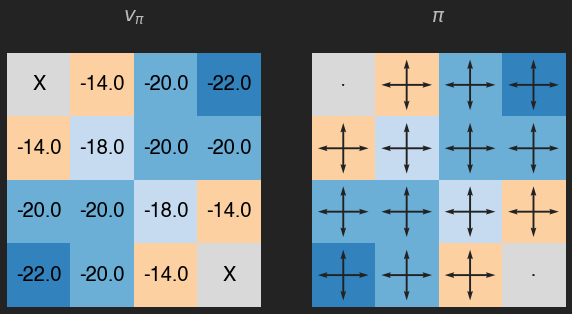

In [42]:
v = eval_pol(pi, its=1000)
plot_env(v, title="$v_\pi$")

Recuerda que el valor de cada estado es la recompensa esperada (en promedio), que en este caso además se puede interpretar como el número de movimientos (en promedio) que nuestro agente debería llevar a cabo para llegar a un estado termrnal. Como podemos ver las casillas con un valor más pequeño son aquellas que requieren más pasos para llegar a los estados terminales, y en este caso la política está lejos de ser óptima.

## Mejorando la política

El motivo para calcular la función de valor de una política es poder encontrar políticas mejores. Imaginemos que hemos calculado la función de valor para una política determinística arbitraria $\pi$ y queremos saber si deberíamos escoger una acción $a \neq \pi(s)$. Para ello podemos considerar la nueva política

$$
    \pi'(s) = \underset{a}{\arg\max}  \, q_\pi(s,a) = \underset{a}{\arg\max} \, \sum_{s',r} p(s',r|s,a) [r + \gamma v_\pi(s')]
$$

Escogiendo de manera *greedy* en cada estado aquella acción que maximiza el término de la derecha. Podemos entonces evaluar la función de valor de la nueva política, $v_{\pi'}$, y volver a mejorarla para encontrar $\pi''$, y así sucesivamente hasta encontrar la política óptima.

In [43]:
def eval_q(v, gamma=1):
    q = np.zeros((16, 4))
    for s in range(16):
        for a in range(4):
            q[s,a] = np.sum([
                    probas_transiciones[s][a][sp]*(recompensas[s][a][sp] + gamma*v[sp]) 
                    for sp in range(16)
                ])
    return q

In [44]:
def greedy_pol(q):
	p = np.zeros((16,4))
	p[range(16), q.argmax(axis=1)] = 1 
	return p

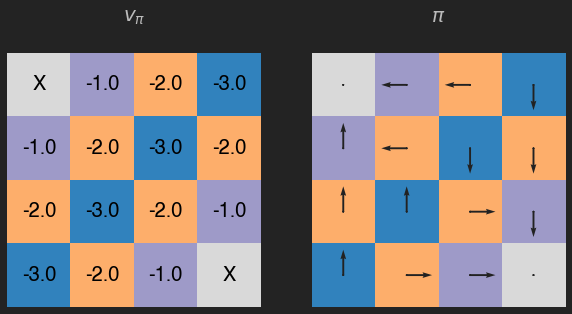

In [45]:
q = eval_q(v)
pi = greedy_pol(q)

v = eval_pol(pi, its=1000)
plot_env(v, pi, title="$v_\pi$")

En este caso encontramos la política óptima con sólo una iteración, en el caso contrario deberíamos repetir el proceso.

$$
\pi_0 \rightarrow v_{\pi_0} \rightarrow  \pi_1 \rightarrow v_{\pi_1} \rightarrow ... \rightarrow \pi_* \rightarrow v_*
$$

Este método se conoce por el nombre de *policy iteration* y si bien suele ser muy eficiente, requiere un doble bucle (uno para cada política y otro para su evaluación). Es posible resolver el problema con un solo bucle con el método de *value iteration*, que básicamente consiste en usar una sola iteración en la fase de evaluación de la política.

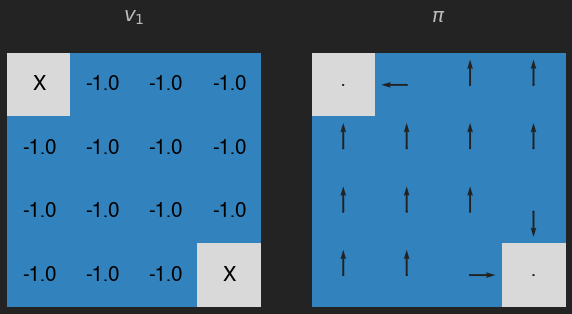

In [48]:
v = eval_pol(pi, its=1) # value iteration !!!
q = eval_q(v)
pi = greedy_pol(q)

plot_env(v, pi, title="$v_1$")

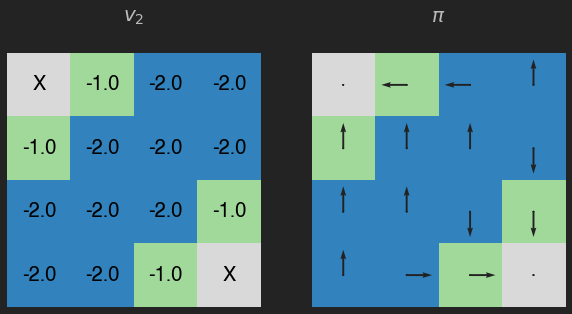

In [50]:
v = eval_pol(pi, its=1, v=v) # value iteration !!!
q = eval_q(v)
pi = greedy_pol(q)

plot_env(v, pi, title="$v_2$")

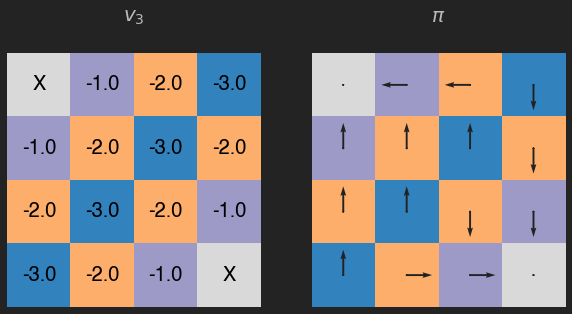

In [51]:
v = eval_pol(pi, its=1, v=v) # value iteration !!!
q = eval_q(v)
pi = greedy_pol(q)

plot_env(v, pi, title="$v_3$")

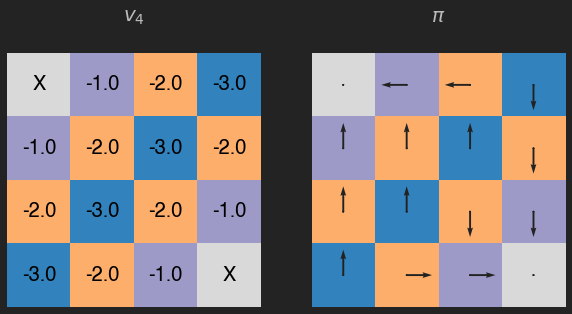

In [52]:
v = eval_pol(pi, its=1, v=v) # value iteration !!!
q = eval_q(v)
pi = greedy_pol(q)

plot_env(v, pi, title="$v_4$")

Para este ejemplo sencillo, 3 iteraciones del método *value iteration* son suficentes.

![](./pics/value_iteration.png)

## Resumen

Hemos visto las ideas básicas de los algoritmos de programación dinámica y cómo resolver MDPs finitos. Hablamos de *evaluación de la política* cuando, de manera iterativa, calculamos la función de valor de una política determinada. Podemos mejorar la política escogiendo aquellas acciones que maximizen el retorno esperado con la función de valor evaluada anteriormente de manera *greedy*. Si repetimos este processo, llegaremos a encontrar la política óptima.

Los métodos de programación dinámica operan haciendo un barrido de todo el espacio de estados, calculando el valor de cada estado basado en el valor de todos los posibles estados sucesivos ponderados por su probabilidad de ocurrir. Esto puede resultar en un factor limitador en aquellos casos en los que el número de estados sea muy grande (aunque técnicas como la *programación dinámica asíncrona* puede aliviar este problema en ocasiones).